## Evaluator-Optimizer Workflow
<< TODO -- change the text description. Image is ok>>

In this workbook we'll build a workflow that illustrates _Evaluator-Optimizer_ workflow. This is very similar to the [Orchestrator-Worker workflow](05-Orchestrator-Worker.ipynb), which we saw in the previous workbook. In both these cases we have a LLM directing the control of workflow through pre-defined code execution paths. In this, _Evaluator-Optimizer_ workflow, we have one LLM generate a response, and another to kind of grade it and give feedback in a loop.

This can be used, for example, to grade responses from a RAG system for hallucinations or for factual accuracy. If there is hallucination in the output that isn't grounded by the documents, then we can send it back and have it regenerate a response.

<div align="center">
<img src="images/06-Evaluator-Optimizer.png" width="450" heigh="250" alt="Orchestrator Workflow"/>
</div>

In this example we'll mimic deep research. The LLM will reason about the plan for a report and will dynamically generate a bunch of research sections and then goes about researching each section - classic example of an _Orchestrator-Worker_ type workflow.

In [1]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from rich.markdown import Markdown
from typing import TypedDict, Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

In [2]:
load_dotenv(override=True)

console = Console()

In [3]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.0-flash", temperature=0.4)

C:\Users\BHOBEMRMANISHJAGDISH\Dev\code\git_projects\learning_langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# schema for structured output to use in planning
class Section(BaseModel):
    # a Section will have a name & description
    name: str = Field(
            description="Name for this section of the report",
        ),
    description: str = Field(
        description="""Brief overview of the main topics and concepts to be 
        covered in this section""",
    )


class Sections(BaseModel):
    # Sections (plural) is a collection of Section
    sections: List[Section] = Field(description="Sections of the report")


# our planner LLM
planner_llm = llm.with_structured_output(Sections)

C:\Users\BHOBEMRMANISHJAGDISH\Dev\code\git_projects\learning_langgraph\.venv\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name for this section of the report'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [5]:
# the graph state
class State(TypedDict):
    topic: str  # the joke topic provided by user
    sections: List[Section]
    # all the workers will write to this field (will add sections)
    completed_sections: Annotated[list, operator.add]
    final_report: str


# worker state - each worker also get its own state
# Why? Because you want to hand off independent inputs to each worker
# and they are self-contained objects. Think of it as a separate bucket in which
# work is being done independently, but writing to the same output
class WorkerState(TypedDict):
    section: Section
    # NOTE: this field has the same name/key as that of the Stategraph.
    # In Langchain, what happens is that when you write to this key, the outer
    # key in StateGraph with the same name also gets updated
    completed_sections: Annotated[list, operator.add]

Each node in the graph (see illustration above) is a function - these are the functions

In [6]:
def orchestrator(state: State):
    """orchestrator that generates plan for report"""
    # NOTE: I am calling planner_llm, which is bound to structured output
    report_sections = planner_llm.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def generate_sections(state: WorkerState):
    """worker writes a section of the report"""
    response = llm.invoke(
        [
            SystemMessage(content="Write a section of the report"),
            HumanMessage(
                content=f"""Here is the section name: {state['section'].name} and
                    description: {state['section'].description}"""
            ),
        ]
    )
    # will add to the WorkerState.completed_sections Annotated list
    return {"completed_sections": [response.content]}


def synthesizer(state: State):
    """synthesize the final report from all sections"""
    # list of completed sections
    completed_sections = state["completed_sections"]
    # join all sections into a single report
    completed_sections = "\n\n----\n\n".join(completed_sections)
    return {"final_report": completed_sections}


def assign_workers(state: State):
    """dynamically assign # of workers depending on the count of section
    as reasoned by the LLM"""
    # special LangGraph call to generate N sections as determined by the LLM
    return [Send("generate_sections", {"section": s}) for s in state["sections"]]

In [7]:
# build our graph
builder = StateGraph(State)
# add nodes
builder.add_node("orchestrator", orchestrator)
builder.add_node("generate_sections", generate_sections)
builder.add_node("synthesizer", synthesizer)
# add edges
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["generate_sections"])
builder.add_edge("generate_sections", "synthesizer")
builder.add_edge("synthesizer", END)
graph = builder.compile()

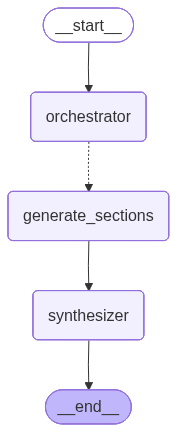

In [8]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# invoke the graph
response = graph.invoke(
    {"topic": "Create a report on applications of Generative AI in Investment Banking"}
)

In [10]:
md = Markdown(response["final_report"])
console.print(md)

Introduction: Generative AI in Investment Banking                                 

Generative Artificial Intelligence (AI) is rapidly transforming industries across the globe, and investment banking
is no exception. This emerging field leverages advanced machine learning models to create new content, ranging from
text and images to code and data, based on patterns learned from existing datasets. Unlike traditional AI focused  
on analysis and prediction, Generative AI empowers machines to generate novel outputs, offering unprecedented      
opportunities to automate tasks, enhance decision-making, and unlock new efficiencies within the complex and       
demanding landscape of investment banking.                                                                         

This report explores the potential of Generative AI to revolutionize various aspects of investment banking         
operations. From streamlining due diligence processes and automating report generation to personalizing client     
interactions and uncovering hidden market insights, Generative AI promises to significantly impact productivity,   
accuracy, and ultimately, profitability. By understanding the capabilities and limitations of these technologies,  
investment banks can strategically leverage Generative AI to gain a competitive edge in a rapidly evolving         
financial landscape.                                                                                               

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                        Applications in Investment Banking                                         

Generative AI is rapidly transforming the landscape of investment banking, offering powerful tools to enhance      
efficiency, personalize client interactions, and improve decision-making. Its applications span across various     
functions, promising significant advancements in productivity and profitability.                                   

Automated Report Generation: Investment banking relies heavily on reports for due diligence, market analysis, and  
regulatory compliance. Generative AI can automate the creation of these reports by extracting relevant information 
from vast datasets, including financial statements, news articles, and market research. This significantly reduces 
the time and effort required for report generation, freeing up analysts to focus on higher-value tasks such as     
strategic analysis and client interaction. AI can also ensure consistency and accuracy across reports, minimizing  
errors and improving overall quality. For example, AI can generate preliminary prospectuses, fairness opinions, and
industry overviews with minimal human intervention, significantly accelerating the deal process.                   

Personalized Client Communication: Maintaining strong client relationships is paramount in investment banking.     
Generative AI enables personalized communication by analyzing client data, including investment history, risk      
tolerance, and preferences. This allows for the creation of tailored investment recommendations, marketing         
materials, and client reports. AI can also generate personalized responses to client inquiries, ensuring timely and
relevant information delivery. By understanding individual client needs, generative AI can foster stronger         
relationships and improve client satisfaction, leading to increased loyalty and business opportunities.            
Furthermore, AI can be used to create customized pitchbooks and presentations, highlighting the specific benefits  
of a proposed transaction for each client.                                                                         

Fraud Detection: Investment banking is vulnerable to various types of fraud, including insider trading, market     
manipulation, and money laundering. Generative AI can analyze vast amounts of tra